## Mars Photogrammetry Preprocessing Pipeline

By Christian Tate, Cornell University; Ithaca, NY



In [1]:
# Import python modules

import numpy as np
import cv2, glob, time, os
import matplotlib.pyplot as plt
# from planetaryimage import PDS3Image
# import colour_demosaicing
# from PIL import Image
# import matplotlib.cm as cm
# from scipy import interpolate
# from scipy.spatial.transform import Rotation as R
# import colour_demosaicing
import pandas as pd

%run MPPP.py
%matplotlib inline

In [42]:
# Set input path to IMG files and search criteria


directory_input = 'C:/Users/cornell/Desktop/data/datadrive'
# directory_input = 'C:/Users/cornell/Desktop/data/zcam'
path_input      = directory_input
# path_input      = 'C:/Users/cornell/Desktop/data/*/data/sol/*/rdr/*'  # engineering cameras
# path_input      = 'C:/Users/cornell/Desktop/data/datadrive/*/ids/rdr/*'  # engineering cameras
# path_input    = 'C:/Users/cornell/Desktop/data/*/data/*/rad/*'        # science cameras

# directory_input = 'Y:/Playground/Simeon/Mars/pds-imaging.jpl.nasa.gov/data/mars2020'
# path_input    = 'Y:/Playground/Simeon/Mars/pds-imaging.jpl.nasa.gov/data/mars2020/mars2020_*_ops_calibrated/data/sol/00477/ids/rdr/*'  # engineering cameras
# path_input    = 'Y:/Playground/Simeon/Mars/pds-imaging.jpl.nasa.gov/data/mars2020/mars2020_mastcamz_sci_calibrated/data/*/rad'    # science cameras

# Set output path
directory_output = 'C:/Users/cornell/Desktop/images'
# directory_output = 'C:/Users/cornell/Desktop'
# directory_output = 'Y:/Playground/Simeon/Mars/pds-imaging.jpl.nasa.gov/images' 

pre = '*MV0'
suf = 'refs_vce'

pre = '*MV0555'
suf = 'refs_vce_555'

# pre = '*_070'
# suf = 'refs_700s'

# pre = 'Z*0_06'
# suf = 'zcam_600s_refs'

# pre = 'Z*0_0'
# suf = 'zcam_refs'

sequ_id = ''

IMG_paths = [] \
          + ( glob.glob(  path_input + '/' +pre+'*R*_N*'+sequ_id+'*.IMG' ) ) 

print( len(IMG_paths), 'images\n')
# IMG_paths

447 images



In [43]:
file_extension = ''

'''
future work: save these calibration prameters as a text files, which we load for each camera
'''

# save images and thereby overwrite existing images
save_im    = 1

# add an alpha channel to the output images
save_mask  = 1

# add transparrent pixels to restore the image's full, standard size
pad_im     = 1
pad_im_z   = 1

# turn on when finding the waypoint offsets
find_offsets_mode = 0

# set the color values
gamma      = 2.2      # gamma value
gamma      = 2        # gamma value

# fraction of the dynamic range to clip off the lower values of image 
clip_low_z = 0.02  # for the Mastcam-Z cameras
clip_low   = 0.1   # for everything else


# scale all the scale parameters below bsy the same number
scale_scale = 18

# color balance parameters for the Mars 2020 science cameras
scale_z,  scale_red_z,  scale_blue_z  = [ 0.9*scale_scale, 0.7 , 1.5  ] # Mastcam-Z 
scale_l,  scale_red_l,  scale_blue_l  = [ 1.0*scale_scale, 0.75, 1.40 ] # SuperCam RMI
scale_s,  scale_red_s,  scale_blue_s  = [ 1.0*scale_scale, 0.85, 1.40 ] # SHERLOC WATSON 

# color balance parameters for the Mars 2020 engineering cameras
scale_n,  scale_red_n,  scale_blue_n  = [ 1.0*scale_scale, 0.75, 1.2  ] # Navcam
scale_f,  scale_red_f,  scale_blue_f  = [ 1.1*scale_scale, 0.78, 1.25 ] # Front Hazcam
scale_r,  scale_red_r,  scale_blue_r  = [ 1.1*scale_scale, 0.78, 1.25 ] # Rear Hazcam
scale_v,  scale_red_v,  scale_blue_v  = [ 1.0*scale_scale, 1.1 , 0.92 ] # Grayscale VCE Navcam
scale_hr, scale_red_hr, scale_blue_hr = [ 1.0*scale_scale, 0.75, 1.43 ] # Inginuity RTE
scale_hn, scale_red_hn, scale_blue_hn = [ 1.0*scale_scale, 1.1 , 0.92 ] # Inginuity Navcam


In [44]:
%%time

%run MPPP.py


pos_lines  = []
error_lines= []
rover_xyzs = []
im_xyzs    = []
rover_rots = []
im_azs     = []
im_els     = []
sols       = []
rmcs       = []
ims        = []
im_save_path  = ''

print( len(IMG_paths), 'images\n')


for i in range(len(IMG_paths))[::1][:]:
    
#     if 1:
    try:    # catch all the images that fail to process
        
        # open image
        im = image( IMG_paths[i] )
        print( i, im.filename )
        
        # Set color processing parameters
        im.scale       = scale_scale
        im.scale_red   = 1
        im.scale_blue  = 1
        im.clip_low    = clip_low
        im.gamma       = gamma
        im.pad_im      = pad_im
        im.save_im     = save_im
        im.save_mask   = save_mask
        im.find_offsets_mode = find_offsets_mode

        # Mars 2020 Mastcam-Z
        if im.cam[0] == 'Z':
            im.scale       = scale_z
            im.scale_red   = scale_red_z
            im.scale_blue  = scale_blue_z
            im.clip_low    = clip_low_z
            im.pad_im      = pad_im_z

        # Mars 2020 SHERLOC WATSON
        if im.cam[0] == 'S':
            im.scale       = scale_s
            im.scale_red   = scale_red_s
            im.scale_blue  = scale_blue_s

        # Mars 2020 SuperCam RMI
        if im.cam[0] == 'L':
            im.scale       = scale_l
            im.scale_red   = scale_red_l
            im.scale_blue  = scale_blue_l

        # Mars 2020 Navcam
        if im.cam[0] == 'N':
            im.scale       = scale_n
            im.scale_red   = scale_red_n
            im.scale_blue  = scale_blue_n

        # Mars 2020 Navcam VCE images
        if 'MV0' in im.IMG_path:
            im.scale       = scale_v
            im.scale_red   = scale_red_v
            im.scale_blue  = scale_blue_v

        # Mars 2020 Front Hazcam
        if im.cam[0] == 'F':
            im.scale       = scale_f
            im.scale_red   = scale_red_f
            im.scale_blue  = scale_blue_f
            im.clip_low    = clip_low/2

        # Mars 2020 Rear Hazcam
        if im.cam[0] == 'R':
            im.scale       = scale_r
            im.scale_red   = scale_red_r
            im.scale_blue  = scale_blue_r
            im.clip_low    = clip_low/2

        # Heli Ingenuity RTE 
        if im.filename[0:3] == 'HSF':
            im.scale       = scale_hr
            im.scale_red   = scale_red_hr
            im.scale_blue  = scale_blue_hr

        # Heli Ingenuity Navcam  
        if im.filename[0:3] == 'HNM':
            im.scale       = scale_hn
            im.scale_red   = scale_red_hn
            im.scale_blue  = scale_blue_hn
        
        # create save directory
        im.save_path_full = make_save_path( im.IMG_path, directory_output, fullpath=True, file_extension = '.png'  ) 
        im.save_path      = make_save_path( im.IMG_path, directory_output, fullpath=False ) 
        im.save_name      = im.save_path_full.split('/')[-1]
        csv_save_path     = im.save_path
        
        # process and save image
        if im.save_im:
            
            im.image_process( )

            if im.save_mask:
                im.im8a = cv2.cvtColor( im.im8, cv2.COLOR_BGR2RGBA )
                im.im8a[:,:,3] = im.mask_im
                cv2.imwrite( im.save_path_full, im.im8a )                
            else:
                cv2.imwrite( im_save_path_full, im.im8[:,:,::-1] )  

        
        # find image position and rotation parameters
        im.image_reference( )

        # save reference data for plotting        
        '''
        future work: replace these lists with pandas dataframes
        '''
        im_xyzs   .append( [ im.X, im.Y, im.Z ] )
        rover_xyzs.append( [ im.X_offset, im.Y_offset, im.Z_offset ] )
        rover_rots.append( im.rot_rover )
        im_azs    .append( im.az )
        im_els    .append( im.el )
        rmcs      .append( im.label['ROVER_MOTION_COUNTER'])
        sols      .append( int(im.label['LOCAL_TRUE_SOLAR_TIME_SOL']) )
        
        # create a line for the reference file
        # Label	 X/East	Y/North	Z/Altitude	Yaw	Pitch	Roll
        pos_line =  im.save_name+'\t'\
                     +str( np.round( im.X,4))+'\t'\
                     +str( np.round( im.Y,4))+'\t'\
                     +str( np.round( im.Z,4))+'\t'\
                     +str( np.round( im.az,2))+'\t'\
                     +str( np.round( im.el,2))+'\t'\
                     +str( np.round( im.rl,2))+'\n'

        if im.filename[0]!='S':
            pos_lines.append( pos_line )

        try:
            print( 'sol {} site {} drive {}  zenith angle {:0.0f} scale {:0.2f}'.
                        format( im.sol, im.site, im.drive, im.el*57.3, im.ftau ) )
        except:
            print( 'sol {} site {} drive {}'.
                        format( im.sol, im.site, im.drive, ) )
        print( '', i, pos_line[:], )
        print( )

    except:
        print( im.filename, 'failed to process! \n' )
        error_lines.append( im.IMG_path +'\n' )
        
        

current_time = time.strftime("%Y%m%d-%H%M%S")

#save image positions as CSV file
csv_save_path = im.save_path+'/positions_'+suf+'_'+current_time+ '.txt'
with open(csv_save_path,'w') as file:
    for pos_line in pos_lines:
        file.write(pos_line)

#save failed images list as TXT
if len(error_lines) > 0:
    csv_save_path = im.save_path+'/failed_'+suf+'_'+current_time+'.txt'
    with open(csv_save_path,'w') as file:
        for error_line in error_lines:
            file.write(error_line)

len( pos_lines )

447 images

0 NLMV0555_0716205675_402RZS_N0265315VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5315  zenith angle 3515 scale 0.66
 0 NLMV0555_0716205675_402RZS_N0265315VCE_15900_0A02LLJ01.png	-2601.2368	317.6339	32.5145	201.53	61.35	0


1 NLMV0555_0716205814_669RZS_N0265328VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5328  zenith angle 3619 scale 0.66
 1 NLMV0555_0716205814_669RZS_N0265328VCE_15900_0A02LLJ01.png	-2602.9432	313.149	32.9382	212.69	63.16	0


2 NLMV0555_0716206022_052RZS_N0265350VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5350  zenith angle 3550 scale 0.67
 2 NLMV0555_0716206022_052RZS_N0265350VCE_15900_0A02LLJ01.png	-2603.7217	312.2217	33.0388	216.21	61.95	0


3 NLMV0555_0716206175_184RZS_N0265373VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5373  zenith angle 3424 scale 0.67
 3 NLMV0555_0716206175_184RZS_N0265373VCE_15900_0A02LLJ01.png	-2604.4087	314.0097	32.9903	291.96	59.75	0


4 NLMV0555_0716206288_428RZS_N0265373VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5373  

37 NLMV0555_0716208115_177RZS_N0265606VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5606  zenith angle 3125 scale 0.70
 37 NLMV0555_0716208115_177RZS_N0265606VCE_16000_0A02LLJ01.png	-2614.5	338.9211	32.3024	28.0	54.53	0


38 NLMV0555_0716208145_371RZS_N0265606VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5606  zenith angle 3124 scale 0.70
 38 NLMV0555_0716208145_371RZS_N0265606VCE_16000_0A02LLJ01.png	-2614.5001	338.9213	32.3024	28.0	54.53	0


39 NLMV0555_0716208185_774RZS_N0265612VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5612  zenith angle 3165 scale 0.70
 39 NLMV0555_0716208185_774RZS_N0265612VCE_16000_0A02LLJ01.png	-2613.9859	339.8415	32.2438	19.66	55.24	0


40 NLMV0555_0716208216_538RZS_N0265612VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5612  zenith angle 3165 scale 0.70
 40 NLMV0555_0716208216_538RZS_N0265612VCE_15900_0A02LLJ01.png	-2613.9861	339.8415	32.2439	19.66	55.24	0


41 NLMV0555_0716208284_384RZS_N0265625VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5625  zenith angl

sol 555 site 26 drive 5799  zenith angle 3729 scale 0.72
 73 NLMV0555_0716209893_137RZS_N0265799VCE_16000_0A02LLJ01.png	-2635.5089	331.0965	34.5253	223.61	65.08	0


74 NLMV0555_0716209922_152RZS_N0265803VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5803  zenith angle 3699 scale 0.72
 74 NLMV0555_0716209922_152RZS_N0265803VCE_15900_0A02LLJ01.png	-2636.2198	330.4241	34.6675	227.03	64.56	0


75 NLMV0555_0716209949_102RZS_N0265805VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5805  zenith angle 3754 scale 0.72
 75 NLMV0555_0716209949_102RZS_N0265805VCE_16000_0A02LLJ01.png	-2636.8793	329.8294	34.8189	230.35	65.52	0


76 NLMV0555_0716209985_527RZS_N0265811VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5811  zenith angle 3607 scale 0.72
 76 NLMV0555_0716209985_527RZS_N0265811VCE_16000_0A02LLJ01.png	-2637.6808	329.2576	34.9026	234.24	62.96	0


77 NLMV0555_0716210017_726RZS_N0265817VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5817  zenith angle 3602 scale 0.72
 77 NLMV0555_0716210017_726RZS_N026

110 NLMV0555_0716211167_292RZS_N0265984VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5984  zenith angle 3477 scale 0.72
 110 NLMV0555_0716211167_292RZS_N0265984VCE_16000_0A02LLJ01.png	-2668.2318	328.523	37.7732	274.26	60.68	0


111 NLMV0555_0716211191_053RZS_N0265991VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5991  zenith angle 3556 scale 0.72
 111 NLMV0555_0716211191_053RZS_N0265991VCE_16000_0A02LLJ01.png	-2668.2604	328.3611	37.7993	265.07	62.06	0


112 NLMV0555_0716211228_528RZS_N0265997VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5997  zenith angle 3540 scale 0.72
 112 NLMV0555_0716211228_528RZS_N0265997VCE_16000_0A02LLJ01.png	-2669.1636	328.4994	37.8644	270.66	61.78	0


113 NLMV0555_0716211256_430RZS_N0266001VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6001  zenith angle 3417 scale 0.72
 113 NLMV0555_0716211256_430RZS_N0266001VCE_16000_0A02LLJ01.png	-2670.2313	328.5923	37.8956	269.76	59.63	0


114 NLMV0555_0716211282_679RZS_N0266003VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 

146 NLMV0555_0716212391_981RZS_N0266165VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6165  zenith angle 3670 scale 0.72
 146 NLMV0555_0716212391_981RZS_N0266165VCE_16000_0A02LLJ01.png	-2702.4815	330.7613	40.6115	263.03	64.04	0


147 NLMV0555_0716212424_910RZS_N0266171VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6171  zenith angle 3642 scale 0.72
 147 NLMV0555_0716212424_910RZS_N0266171VCE_16000_0A02LLJ01.png	-2703.4614	330.7365	40.7045	262.77	63.56	0


148 NLMV0555_0716212458_006RZS_N0266177VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6177  zenith angle 3578 scale 0.72
 148 NLMV0555_0716212458_006RZS_N0266177VCE_16000_0A02LLJ01.png	-2704.4834	330.7044	40.7917	262.02	62.45	0


149 NLMV0555_0716212491_399RZS_N0266183VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 6183  zenith angle 3625 scale 0.72
 149 NLMV0555_0716212491_399RZS_N0266183VCE_15900_0A02LLJ01.png	-2705.4465	330.6639	40.9158	263.05	63.27	0


150 NLMV0555_0716212545_910RZS_N0266188VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive

182 NLMV0555_0716214853_445RZS_N0266327VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6327  zenith angle 3374 scale 0.69
 182 NLMV0555_0716214853_445RZS_N0266327VCE_16000_0A02LLJ01.png	-2732.7651	331.1755	43.4586	272.42	58.89	0


183 NLMV0555_0716214887_772RZS_N0266333VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6333  zenith angle 3469 scale 0.69
 183 NLMV0555_0716214887_772RZS_N0266333VCE_16000_0A02LLJ01.png	-2733.6966	331.2745	43.5131	270.27	60.53	0


184 NLMV0555_0716214922_912RZS_N0266339VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 6339  zenith angle 3385 scale 0.69
 184 NLMV0555_0716214922_912RZS_N0266339VCE_15900_0A02LLJ01.png	-2734.7001	331.334	43.5375	268.23	59.07	0


185 NLMV0555_0716214957_052RZS_N0266345VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6345  zenith angle 3427 scale 0.69
 185 NLMV0555_0716214957_052RZS_N0266345VCE_16000_0A02LLJ01.png	-2735.6671	331.4224	43.6019	269.5	59.8	0


186 NLMV0555_0716214990_883RZS_N0266351VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 63

218 NLMV0555_0716216488_732RZS_N0266512VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6512  zenith angle 3321 scale 0.66
 218 NLMV0555_0716216488_732RZS_N0266512VCE_16000_0A02LLJ01.png	-2763.304	337.406	45.4231	299.87	57.97	0


219 NLMV0555_0716216505_429RZS_N0266512VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 6512  zenith angle 3321 scale 0.66
 219 NLMV0555_0716216505_429RZS_N0266512VCE_15900_0A02LLJ01.png	-2763.2864	337.4144	45.4241	299.87	57.97	0


220 NLMV0555_0716216547_758RZS_N0266519VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6519  zenith angle 3533 scale 0.65
 220 NLMV0555_0716216547_758RZS_N0266519VCE_16000_0A02LLJ01.png	-2763.6152	337.0521	45.4934	270.76	61.66	0


221 NLMV0555_0716216571_319RZS_N0266525VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6525  zenith angle 3722 scale 0.65
 221 NLMV0555_0716216571_319RZS_N0266525VCE_16000_0A02LLJ01.png	-2763.6348	336.592	45.5547	242.51	64.95	0


222 NLMV0555_0716216599_784RZS_N0266530VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 65

254 NRMV0555_0716207767_272RZS_N0265559VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5559  zenith angle 2870 scale 0.70
 254 NRMV0555_0716207767_272RZS_N0265559VCE_16000_0A02LLJ01.png	-2616.5802	335.9468	32.5062	3.98	50.08	0


255 NRMV0555_0716207805_539RZS_N0265565VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5565  zenith angle 3019 scale 0.70
 255 NRMV0555_0716207805_539RZS_N0265565VCE_16000_0A02LLJ01.png	-2616.4846	336.9609	32.4469	0.92	52.69	0


256 NRMV0555_0716207873_432RZS_N0265575VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5575  zenith angle 2955 scale 0.70
 256 NRMV0555_0716207873_432RZS_N0265575VCE_15900_0A02LLJ01.png	-2615.9192	336.747	32.43	34.73	51.56	0


257 NRMV0555_0716207965_039RZS_N0265587VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5587  zenith angle 2954 scale 0.70
 257 NRMV0555_0716207965_039RZS_N0265587VCE_16000_0A02LLJ01.png	-2615.9042	336.6908	32.4321	36.97	51.55	0


258 NRMV0555_0716207988_615RZS_N0265589VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5589  ze

290 NRMV0555_0716209689_912RZS_N0265775VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5775  zenith angle 3396 scale 0.72
 290 NRMV0555_0716209689_912RZS_N0265775VCE_16000_0A02LLJ01.png	-2632.1878	333.2504	33.9537	271.11	59.28	0


291 NRMV0555_0716209720_527RZS_N0265779VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5779  zenith angle 3504 scale 0.72
 291 NRMV0555_0716209720_527RZS_N0265779VCE_16000_0A02LLJ01.png	-2633.3059	333.2178	34.0309	264.08	61.16	0


292 NRMV0555_0716209747_104RZS_N0265779VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5779  zenith angle 3701 scale 0.72
 292 NRMV0555_0716209747_104RZS_N0265779VCE_15900_0A02LLJ01.png	-2634.2813	333.0314	34.1901	258.17	64.59	0


293 NRMV0555_0716209799_535RZS_N0265780VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5780  zenith angle 3775 scale 0.72
 293 NRMV0555_0716209799_535RZS_N0265780VCE_16000_0A02LLJ01.png	-2635.1821	332.7819	34.3091	253.0	65.89	0


294 NRMV0555_0716209829_419RZS_N0265787VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 

326 NRMV0555_0716210923_787RZS_N0265949VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5949  zenith angle 3493 scale 0.72
 326 NRMV0555_0716210923_787RZS_N0265949VCE_16000_0A02LLJ01.png	-2663.0637	326.9138	37.4226	257.2	60.96	0


327 NRMV0555_0716210954_177RZS_N0265955VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5955  zenith angle 3536 scale 0.72
 327 NRMV0555_0716210954_177RZS_N0265955VCE_15900_0A02LLJ01.png	-2663.9833	326.792	37.5076	259.96	61.7	0


328 NRMV0555_0716210983_287RZS_N0265961VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5961  zenith angle 3385 scale 0.72
 328 NRMV0555_0716210983_287RZS_N0265961VCE_16000_0A02LLJ01.png	-2663.5148	327.2535	37.4416	288.73	59.07	0


329 NRMV0555_0716211017_324RZS_N0265965VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5965  zenith angle 3428 scale 0.72
 329 NRMV0555_0716211017_324RZS_N0265965VCE_16000_0A02LLJ01.png	-2664.3628	327.6735	37.4995	292.02	59.83	0


330 NRMV0555_0716211044_238RZS_N0265967VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 59

362 NRMV0555_0716212149_133RZS_N0266129VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 6129  zenith angle 3582 scale 0.72
 362 NRMV0555_0716212149_133RZS_N0266129VCE_15900_0A02LLJ01.png	-2695.6643	331.4087	39.9337	264.57	62.51	0


363 NRMV0555_0716212181_634RZS_N0266135VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6135  zenith angle 3555 scale 0.72
 363 NRMV0555_0716212181_634RZS_N0266135VCE_16000_0A02LLJ01.png	-2696.6636	331.3698	40.0147	264.65	62.05	0


364 NRMV0555_0716212215_277RZS_N0266141VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6141  zenith angle 3529 scale 0.72
 364 NRMV0555_0716212215_277RZS_N0266141VCE_16000_0A02LLJ01.png	-2697.6779	331.3048	40.0872	264.61	61.59	0


365 NRMV0555_0716212269_178RZS_N0266146VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6146  zenith angle 3526 scale 0.72
 365 NRMV0555_0716212269_178RZS_N0266146VCE_16000_0A02LLJ01.png	-2698.657	331.2725	40.1723	264.44	61.53	0


366 NRMV0555_0716212296_364RZS_N0266151VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 

398 NRMV0555_0716214597_487RZS_N0266297VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6297  zenith angle 3401 scale 0.69
 398 NRMV0555_0716214597_487RZS_N0266297VCE_16000_0A02LLJ01.png	-2726.7583	331.1251	42.9221	288.21	59.35	0


399 NRMV0555_0716214644_899RZS_N0266303VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6303  zenith angle 3415 scale 0.69
 399 NRMV0555_0716214644_899RZS_N0266303VCE_16000_0A02LLJ01.png	-2727.4943	331.6165	42.9695	294.7	59.6	0


400 NRMV0555_0716214677_038RZS_N0266309VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6309  zenith angle 3575 scale 0.69
 400 NRMV0555_0716214677_038RZS_N0266309VCE_16000_0A02LLJ01.png	-2727.9961	331.2251	43.0513	266.27	62.39	0


401 NRMV0555_0716214711_114RZS_N0266313VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6313  zenith angle 3626 scale 0.69
 401 NRMV0555_0716214711_114RZS_N0266313VCE_16000_0A02LLJ01.png	-2728.8681	331.265	43.1568	269.92	63.27	0


402 NRMV0555_0716214765_027RZS_N0266314VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 63

434 NRMV0555_0716216165_788RZS_N0266477TRAV00218_0A02LLJ01.IMG
sol 555 site 26 drive 6477  zenith angle 3475 scale 0.66
 434 NRMV0555_0716216165_788RZS_N0266477TRAV00218_0A02LLJ01.png	-2757.3938	335.3517	45.0565	264.17	60.64	0


435 NRMV0555_0716216223_555RZS_N0266482VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6482  zenith angle 3514 scale 0.66
 435 NRMV0555_0716216223_555RZS_N0266482VCE_16000_0A02LLJ01.png	-2758.2796	335.4947	45.1198	269.35	61.33	0


436 NRMV0555_0716216253_805RZS_N0266487VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6487  zenith angle 3444 scale 0.66
 436 NRMV0555_0716216253_805RZS_N0266487VCE_16000_0A02LLJ01.png	-2759.1593	335.7192	45.1499	275.48	60.11	0


437 NRMV0555_0716216282_160RZS_N0266489VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 6489  zenith angle 3491 scale 0.66
 437 NRMV0555_0716216282_160RZS_N0266489VCE_15900_0A02LLJ01.png	-2759.9375	336.0456	45.2085	281.95	60.93	0


438 NRMV0555_0716216311_555RZS_N0266495VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive

447

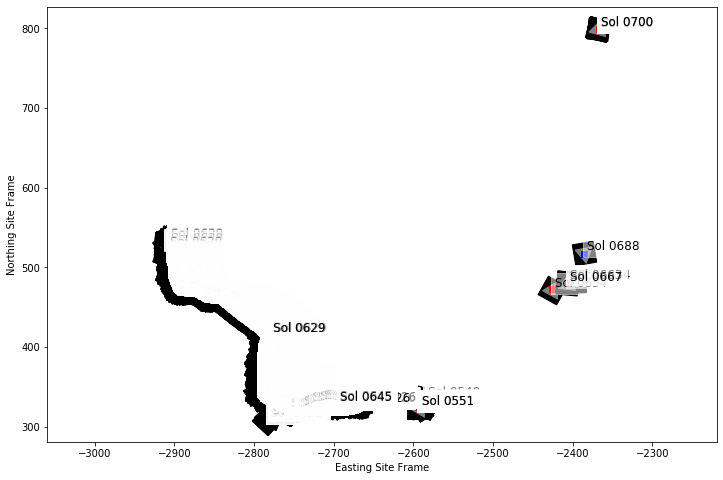

In [20]:
%run MPPP.py

# plot image and rover locations

plot_image_locations( IMG_paths, im_xyzs, rover_xyzs, rover_rots, im_azs, im_els )

## Ignore the notes below

In [6]:
# '''
# df_refs : pandas dataframe that holds reference info for each image

# data saves in the output directory as a CSV file 'df'+output+'.csv' and as a python pickle 'df'+output+'.pkl'

# '''

# df_refs = pd.DataFrame( 
#     columns = [ 
#         'sol',           # sol number or Mars day since landing is a natural way to describe images.
#         'site',          # site index for the rover's location, site 3 is the landing site
#         'drive',         # drive index is where the rover is relative to the current site frame
#         'time',          # datetime of image capture
        
#         'xyz_enu',       # postition XYZ values in meters ENU = [xEast, yNorth, zUp ] from site 3 (note: as Metashape interprets XYZ)
#         'xyz_ned',       # postition XYZ values in meters NED = [xNorth, yEast, zDown] from site 3
#         'rot_rpy',       # rotation angles in RPY = [roll, pitch, yaw] in degrees (as Metashape interprets roll-pitch-yaw)
#         'rot_ypr',       # rotation angles in YPR = [yaw, pitch, roll] in degrees 
#         'rot_opk',       # rotation angles in OPK = [omega, phi, kappa] in degrees 
        
#         'site_wy',       # waypoint site index, same as the current site if 'site_wy' == 'site' 
#         'drive_wp',      # waypoint drive index, same as the current drive if 'drive_wy' == 'drive'      
#         'xyz_wp',        # waypoint postition XYZ values in meters NED = [xNorthing, yEasting, zElevation]
#         'xyz_site3'      # postition of site3 (OEB landing site) in meters NED = [xNorth, yEast, zDown], 'xyz_site3'=[0,0,0] if site3 is the default reference frame
#         'nee_site3'      # postition of site3 (OEB landing site) in meters NED = [xNorthing, yEasting, zElevation]
#         'lle_site3'      # postition in [longitude, latitude, elevation] Mars global coordinates        
       
#         'cahvor',        # the CAHVOR or CAHVORE camera model in rover frame [xFront, yRight, zDown]
#         'az_site',       # site-frame azimuth pointing in degrees clockwise from the North vector 
#         'el_site',       # site-frame elevation pointing in degrees positive from the horizone
#         'az_rover',      # rover-frame azimuth pointing in degrees clockwise from the rover's forward vector
#         'el_rover',      # rover-frame elevation pointing in degrees positive from the forward-right plane       
        
#         'ref',           # string that forms the image's line in the reference file for import to software (Metashape)
#         'filename',      # file name with .IMG extension
#         'filepath',      # complete file path to image at run time
# ])


# df_refs

In [7]:
# ignore the below cells

In [8]:
# For find_offset_mode = 1

# # pos_lines  = []
# # rover_xyzs = []
# # im_xyzs    = []
# # sols       = []
# # rmcs = []
sites  = [ rmcs[i][0] for i in range(len(rmcs))[::-1] ]
drives = [ rmcs[i][1] for i in range(len(rmcs))[::-1] ]
Xs     = [ rover_xyzs[i][0] for i in range(len(rover_xyzs))[::-1] ]
Ys     = [ rover_xyzs[i][1] for i in range(len(rover_xyzs))[::-1] ]
Zs     = [ rover_xyzs[i][2] for i in range(len(rover_xyzs))[::-1] ]

table = np.stack( [sols[::-1], sites, drives, Xs, Ys, Zs], axis=1)
np.round( table, 4 )

np.savetxt( directory_output+"/offsets.csv", table, delimiter="\t")

In [9]:
# Scam flatfield

path = 'C:/Users/cornell/Mastcam-Z/ws/seitah'
pre = 'L*_0510*'

RAD_paths = [] \
          + sorted( glob.glob(  path + '/' +pre+'*R*_N*.IMG' ) ) \

RAD_paths

ims = []
for i in range(len(RAD_paths))[:]:
    
    im_image = PDS3Image.open( RAD_paths[i] ).image
    ims.append( np.float64( im_image) )
    
flat = np.mean( ims, axis=0)
for i in range(3):
    flat[:,:,i] /= np.mean( flat[700:-700,700:-700,i] )
    
plt.imshow( flat/1.5 )

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-7c04ccbb467f>", line 19, in <module>
    flat[:,:,i] /= np.mean( flat[700:-700,700:-700,i] )
IndexError: invalid index to scalar variable.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'IndexError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\ProgramData\

IndexError: invalid index to scalar variable.

In [ ]:
x = np.arange(0, 2048)
y = np.arange(0, 2048)
xv, yv = np.meshgrid(x, y)

y0, x0, r0, p = [900,1000,1000,3]
dv = ( (xv-x0)**2 + (yv-y0)**2 )**(p/2)
dv /= (r0**p)*2
dv += 1

# lim = .8
# dv[ dv<lim]  =lim

dflat = flat.copy()
for i in range(3):
    dflat[:,:,i] *= dv
    
plt.imshow( dflat/2 )
plt.colorbar()

In [ ]:
dvl = np.mean( dflat[:,1000:1300], axis=1)
plt.plot(dvl)

dvl = np.mean( flat[:,1000:1300], axis=1)
plt.plot(dvl)
# flat = dflat.copy()

In [ ]:
import urllib.request, json 

'''

https://mars.nasa.gov/mmgis-maps/M20/Layers/json/M20_waypoints.json

https://docs.google.com/spreadsheets/d/1GSNJL-e5iROCaKUC4BXL_OA8hWy8vUdfCN7levRNkZA/edit#gid=1232397498

''' 
# path =  'C:/Users/cornell/Downloads/M20_waypoints.json'
# with open( path ) as f:
#     data = json.load(f)

with urllib.request.urlopen("https://mars.nasa.gov/mmgis-maps/M20/Layers/json/M20_waypoints.json") as url:
    data = json.loads(url.read().decode())

    
site3_E = data['features'][0]['properties']['easting']
site3_N = data['features'][0]['properties']['northing']
site3_A = data['features'][0]['properties']['elev_geoid']


for i in range(len(data['features']))[::-1]:
    
    print( data['features'][i]['properties']['sol'],'\t',
           data['features'][i]['properties']['site'], '\t',
           data['features'][i]['properties']['drive'],'\t',
           ''+'\t',''+'\t',''+'\t',
           np.round( np.float64(data['features'][i]['properties']['easting'])- np.float64(site3_E), 3),'\t',
           np.round( np.float64(data['features'][i]['properties']['northing'])- np.float64(site3_N), 3),'\t',
           np.round( np.float64(data['features'][i]['properties']['elev_geoid'])- np.float64(site3_A), 3),'\t',
         )

In [ ]:
site  = 30
drive = 600

df_off = pd.read_csv( 'M2020_waypoint_offsets.csv')



In [ ]:
site  = 30
drive = 600

df_off = pd.read_csv( 'M2020_waypoint_offsets.csv')

# search the M2020_waypoint_offsets.csv file  

# if there is a row for the specific site and drive values

# if interpolate between rows that bracket the specific site and drive values

# if above fails

# download M20_waypoints.json and search for specific site and drive values

# if found then append a line to the M2020_waypoint_offsets.csv file

# if non found then raise error and return NaNs

ss = df_off.site==site
ds = df_off.drive   [ ss ]
xs = df_off.offset_x[ ss ]
ys = df_off.offset_y[ ss ]
zs = df_off.offset_z[ ss ]

x_shift = np.interp( drive, ds, xs)
y_shift = np.interp( drive, ds, ys)
z_shift = np.interp( drive, ds, zs)